# 1.Import Library dan Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Impor pustaka yang diperlukan
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import os
import torchvision
import random
import shutil
from torchsummary import summary
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, Resize, ToTensor, Normalize



#2. Direktori sumber dan Tujuan

In [ ]:
# Define the source and destination directories
data_dir = "/content/drive/MyDrive/dataset/coba"
dest_dir = "/content/drive/MyDrive/dataset/dest"

#3. Pre-processing


In [ ]:
# membagi data menjadi 80% train, 20% uji model
split_ratio = 0.2
validation_split = 0.2

In [ ]:
# Iterasi melalui setiap subfolder dalam direktori sumber dan membagi data menjadi set pelatihan dan pengujian.
for root, dirs, files in os.walk(data_dir):
    if files:
        # Create corresponding subfolders in the destination directory
        dest_root = os.path.join(dest_dir, os.path.relpath(root, data_dir))
        os.makedirs(os.path.join(dest_root, 'train'), exist_ok=True)  # Create train directory
        os.makedirs(os.path.join(dest_root, 'test'), exist_ok=True)   # Create test directory

        # Randomly shuffle the files
        random.shuffle(files)

        # Calculate the number of files for the train and test sets
        num_files = len(files)
        num_train_files = int(num_files * split_ratio)
        train_files = files[:num_train_files]
        test_files = files[num_train_files:]

        # Copy the train and test files to their respective subfolders
        for file in train_files:
            src_path = os.path.join(root, file)
            dest_path = os.path.join(dest_root, 'train', file)
            shutil.copy2(src_path, dest_path)

        for file in test_files:
            src_path = os.path.join(root, file)
            dest_path = os.path.join(dest_root, 'test', file)
            shutil.copy2(src_path, dest_path)

print("Data splitting completed.")

Data splitting completed.


#4. Data Transform

In [ ]:
data_dir = "/content/drive/MyDrive/dataset/dest"

In [ ]:
# Membuat transformasi data untuk mengubah ukuran gambar, mengonversi gambar ke tensor PyTorch, dan normalisasi.
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # InceptionV3 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
# Create a dataset from your image folder with subfolders
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Calculate the sizes for the training and validation sets
num_data = len(dataset)
num_valid = int(validation_split * num_data)
num_train = num_data - num_valid


In [ ]:
# Define the root directory where your data is located
data_root = "/content/drive/MyDrive/dataset/dest"  # Your dataset root directory

# Define the transformation to apply to your images
transform = Compose([
    Resize((224, 224)),  # Resize the images to a consistent size
    ToTensor(),           # Convert images to PyTorch tensors
    Normalize(            # Normalize the pixel values
        mean=[0.485, 0.456, 0.406],  # Mean values for RGB channels
        std=[0.229, 0.224, 0.225]    # Standard deviation for RGB channels
    )
])


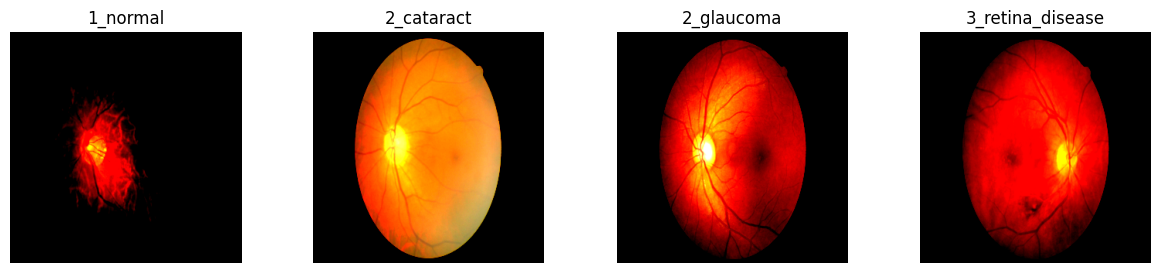

In [ ]:
def show_one_sample_per_class(dataset):
    num_classes = len(dataset.classes)
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 3))

    for class_idx, class_name in enumerate(dataset.classes):
        class_indices = [idx for idx, label in enumerate(dataset.targets) if label == class_idx]
        random_idx = np.random.choice(class_indices)
        sample_image, sample_label = dataset[random_idx]

        ax = axes[class_idx]
        ax.imshow(np.transpose(sample_image, (1, 2, 0)))  # Transpose to (H, W, C)
        ax.set_title(class_name)
        ax.axis('off')

    plt.show()

# Display one sample image from each unique class in the dataset
show_one_sample_per_class(dataset)

# 5. Split Dataset

In [ ]:
# Menghitung ukuran set pelatihan dan validasi.
# Membagi dataset menjadi set pelatihan dan validasi.
train_dataset, valid_dataset = random_split(dataset, [num_train, num_valid])


# 6. Data Loader

In [ ]:
# Create data loaders for training and validation
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 8. Arsitektur Inception V3
- Menggunakan model InceptionV3 yang sudah dilatih.
- Mengganti lapisan fully connected terakhir untuk jumlah kelas yang sesuai dengan dataset.
- Memindahkan model ke perangkat yang sesuai (CPU atau GPU).

In [ ]:
# Use InceptionV3 model
model = models.inception_v3(pretrained=True)
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 122MB/s] 


In [ ]:
# Modify the final fully connected layer for your specific number of classes
num_classes = len(dataset.classes)
model.AuxLogits.fc = nn.Linear(768, num_classes)
model.fc = nn.Linear(2048, num_classes)

In [ ]:
# Move the model to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
summary(model, input_size=(3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

#9. Loss Function dan Optimizer
- Mendefinisikan fungsi loss (Cross-Entropy) dan optimizer (Adam).
- Membuat penjadwalan laju pembelajaran (learning rate scheduler).

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Create a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


#10. Training Model(Loop)
- Melakukan pelatihan model selama beberapa epoch.
- Menghitung loss dan akurasi pada set pelatihan dan validasi.
- Menyimpan loss dan akurasi pada setiap epoch.

In [ ]:
# Training loop
num_epochs = 15
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        predicted = outputs.logits  # Ambil output kelas dari logits
        loss = criterion(predicted, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted_class = torch.max(predicted, 1)  # Peroleh kelas prediksi
        total_train += labels.size(0)
        correct_train += (predicted_class == labels).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = outputs  # Ambil output kelas dari logits
            loss = criterion(predicted, labels)
            valid_loss += loss.item() * inputs.size(0)
            _, predicted_class = torch.max(predicted, 1)  # Peroleh kelas prediksi
            total_valid += labels.size(0)
            correct_valid += (predicted_class == labels).sum().item()

    valid_loss = valid_loss / len(valid_loader.dataset)
    valid_accuracy = 100 * correct_valid / total_valid
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}] => '
          f'Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, Valid Accuracy: {valid_accuracy:.2f}%')

    scheduler.step()

Epoch [1/15] => Train Loss: 1.2175, Valid Loss: 1.0221, Train Accuracy: 50.63%, Valid Accuracy: 61.58%
Epoch [2/15] => Train Loss: 1.0391, Valid Loss: 0.9381, Train Accuracy: 57.81%, Valid Accuracy: 67.23%
Epoch [3/15] => Train Loss: 0.9343, Valid Loss: 0.9155, Train Accuracy: 61.60%, Valid Accuracy: 67.23%
Epoch [4/15] => Train Loss: 0.8959, Valid Loss: 0.8352, Train Accuracy: 65.40%, Valid Accuracy: 71.19%
Epoch [5/15] => Train Loss: 0.8321, Valid Loss: 0.7895, Train Accuracy: 66.39%, Valid Accuracy: 72.88%
Epoch [6/15] => Train Loss: 0.8279, Valid Loss: 0.7909, Train Accuracy: 67.37%, Valid Accuracy: 71.75%
Epoch [7/15] => Train Loss: 0.7717, Valid Loss: 0.7735, Train Accuracy: 70.89%, Valid Accuracy: 71.75%
Epoch [8/15] => Train Loss: 0.7877, Valid Loss: 0.7672, Train Accuracy: 69.06%, Valid Accuracy: 68.93%
Epoch [9/15] => Train Loss: 0.7841, Valid Loss: 0.7721, Train Accuracy: 69.34%, Valid Accuracy: 71.75%
Epoch [10/15] => Train Loss: 0.7664, Valid Loss: 0.7475, Train Accuracy: 

#11. Grafik Loss dan Akurasi
- Menampilkan grafik loss dan akurasi pelatihan dan validasi.


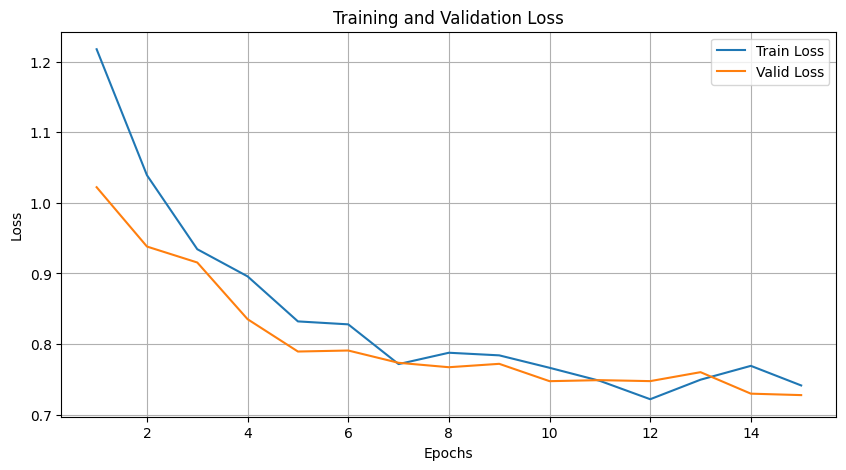

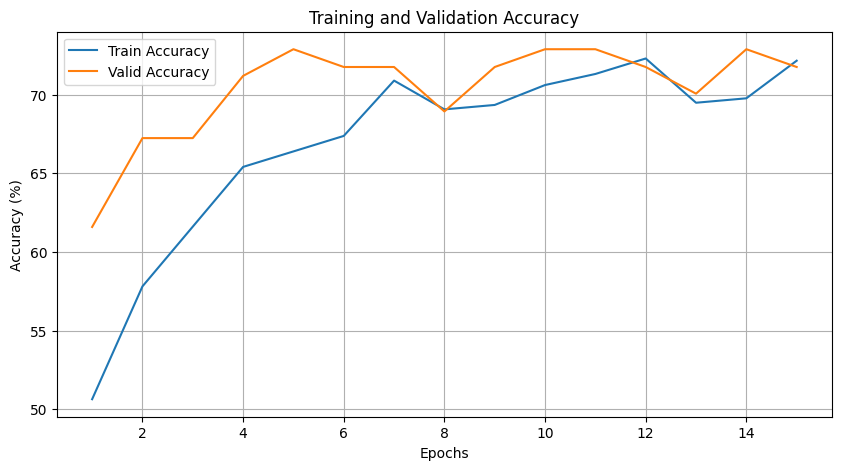

Training completed.


In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print("Training completed.")

In [ ]:
# Setelah bagian pelatihan selesai
test_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Use shuffle=False for testing

# Hitung akurasi pada dataset pengujian
test_correct = 0
test_total = 0
model.eval()  # Set model ke mode evaluasi

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Accuracy on test data: {test_accuracy:.2f}%')

Accuracy on test data: 63.40%
